In [1]:
# Merc.pynb   - Data visualisation and analysis of Mercedes Benz Greener Manufacturing dataset

# Objective   - Predict the length of time required to test a car in the factory. 

# Data source -  'https://www.kaggle.com/c/mercedes-benz-greener-manufacturing'

# Author      -  Adil Khan

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import cluster, linear_model, ensemble, svm, naive_bayes

In [3]:
path = '/Users/Adil/Documents/Data Science/Competitions/Merc'
os.chdir(path)
df = pd.read_csv('train.csv').sample(frac=1)
df.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Analysis

## Categorical or Binary

In [4]:
catFeat = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
numFeat= [i for i in df.columns if i not in catFeat and i != 'ID']

## Missing Values

In [5]:
print('Number of missing values =',df.isnull().sum().sum())

empty = [i for i in numFeat if df[i].sum()==0]
print('Number of columns where all instances are 0 = ' + str(len(empty)))

full = [i for i in numFeat if df[i].sum()==4209]
print('Number of columns where all instances are 1 = ' + str(len(full)))

#Drop empty columns
df=df.drop(empty, axis=1)

Number of missing values = 0
Number of columns where all instances are 0 = 12
Number of columns where all instances are 1 = 0


## Correlations

### Correlations heatmap

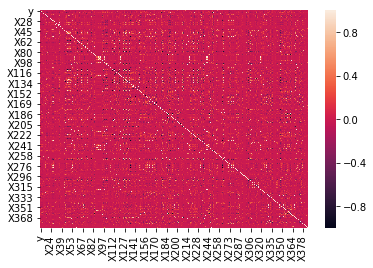

In [6]:
numFeat= [i for i in df.columns if i not in catFeat and i != 'ID']
corr=df[numFeat].corr()
sns.heatmap(corr)


### Feature-Label Correlations

abolute mean = 0.09273427949999191
absolute std = 0.1090028043776752


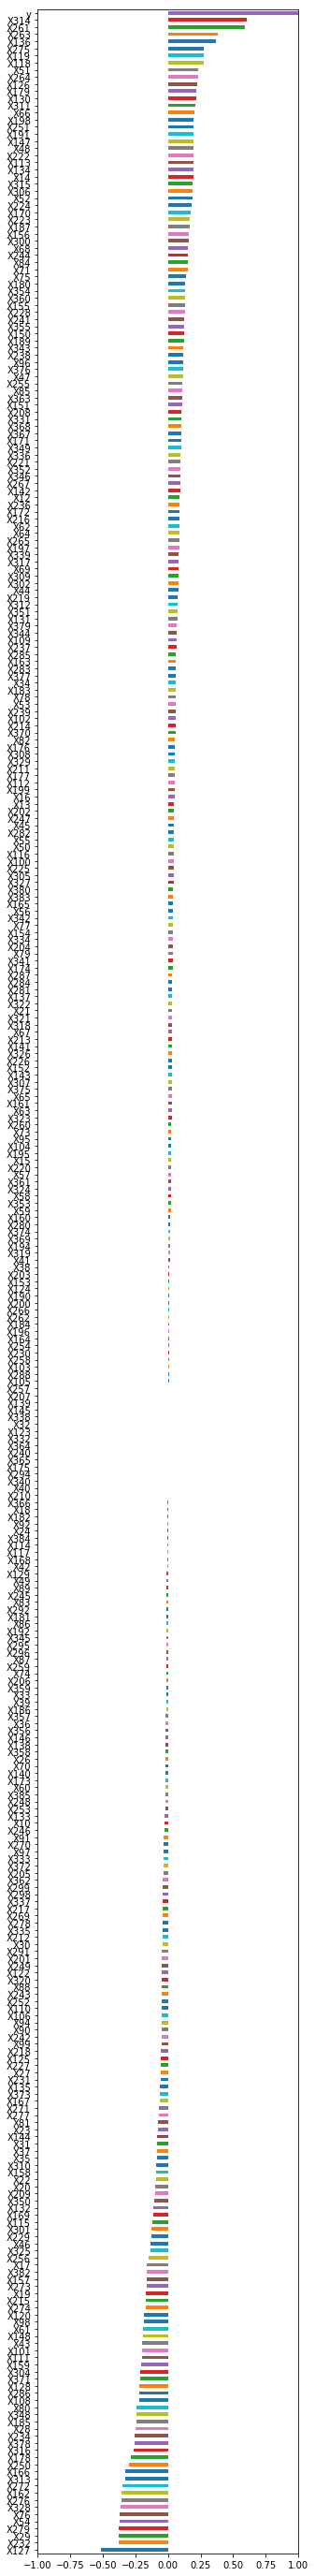

In [7]:
print('abolute mean = ' +str(corr.loc['y'].abs().mean()))
print('absolute std = ' +str(corr.loc['y'].abs().std()))
corr.loc['y'].sort_values().plot.barh(figsize=(5,50),xlim=(-1,1))

### Find and drop duplicate features (i.e. corr = 1 )

In [8]:
duplicated=[]
for i in corr.columns:
    for j in corr.columns:
        if i != j:
            if abs(corr[i].loc[j])==1:
                duplicated.append([i,j])
count=0
for i in duplicated:
    if i[::-1] in duplicated:
         del duplicated[count]
    count += 1
duplicated = [duplicated[i][1] for i in range(len(duplicated))]

df=df.drop(duplicated, axis=1)

# Prepare for analysis

## One Hot Coding

In [9]:
catDummyList = []
for i in catFeat:
    catDummyList.append([])
    i_length = len(df[i].unique())
    catDummyList[-1]=[i+'_dummy_%d' %j for j in range(i_length)]

dummies = pd.DataFrame()
for i,j in enumerate(catFeat):
    x=pd.get_dummies(df[j])
    x.columns = catDummyList[i]
    dummies=pd.concat([dummies, x], axis=1)

## Stack

In [10]:
numFeat= [i for i in df.columns if i not in catFeat and i != 'ID' and i!='y']
stacked = pd.concat([df[numFeat],dummies], axis=1)

## Assign lables, Split data into Training and Testing sets

In [11]:
yList = np.asarray(df['y'])
xList=np.asarray(stacked)

xListTrain = [xList[i] for i in range(len(xList)) if i%4!=0]
xListTest = [xList[i] for i in range(len(xList)) if i%4==0]
yListTrain = [yList[i] for i in range(len(yList)) if i%4!=0]
yListTest = [yList[i] for i in range(len(yList)) if i%4==0]

# Models

## Linear Regression

In [12]:
model = linear_model.LinearRegression()
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest))

	Train Score:	 0.6271862685019376
	Test Score:	 -8.520415318939446e+17


## Ridge Regressions

In [13]:
model = linear_model.Ridge(alpha=100)
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest)) 


	Train Score:	 0.5791028851057407
	Test Score:	 0.5653834829704276


## Lars Lasso Regressions

In [14]:
model = linear_model.LassoLars(alpha=0.01, max_iter=20,eps=0.1)
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest)) 


pathlist=[]
for i in range(len(model.coef_path_[0])):
    for j in range(len(model.coef_path_)):
        if model.coef_path_[j][i] != 0:
            if j not in pathlist:
                pathlist.append(j)

print('\nFirst 10 feature coefficients to become non-zero:\n')
for i in range(10):
    print(stacked.columns[i])

	Train Score:	 0.5422384284086953
	Test Score:	 0.5539315857953878

First 10 feature coefficients to become non-zero:

X10
X12
X13
X14
X15
X16
X18
X19
X20
X21


## Random Forest

	Train Score:	 0.6372143248148976
	Test Score:	 0.5721568623137196


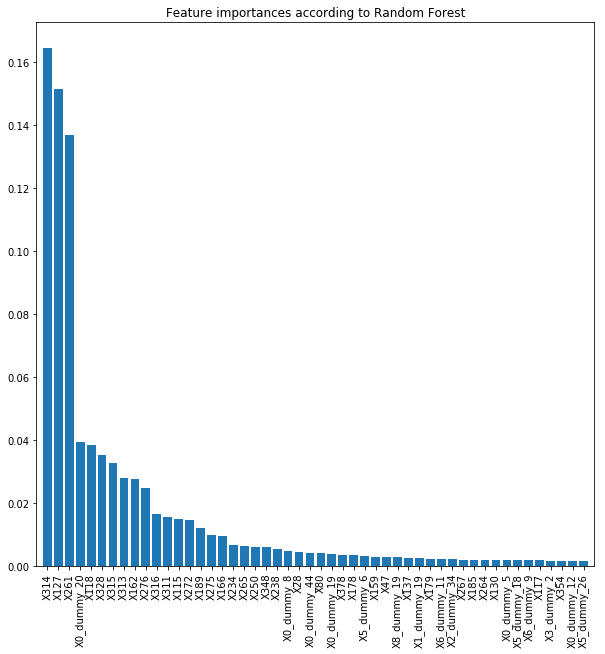

In [15]:
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest)) 

feat_names = stacked.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:50]

plt.figure(figsize=(10,10))
plt.title('Feature importances according to Random Forest')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


## Gradient Boosting

In [16]:
model = ensemble.GradientBoostingRegressor(n_estimators=1000,max_depth=1)
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest))

	Train Score:	 0.6053106478354108
	Test Score:	 0.568879236378905


## Support Vector Regressor

In [17]:
model = svm.SVR()
model.fit(xListTrain,yListTrain)
print('\tTrain Score:\t', model.score(xListTrain,yListTrain))
print('\tTest Score:\t', model.score(xListTest,yListTest)) 

	Train Score:	 0.4034759812319654
	Test Score:	 0.43327077943975323


## Clustering

### KMeans

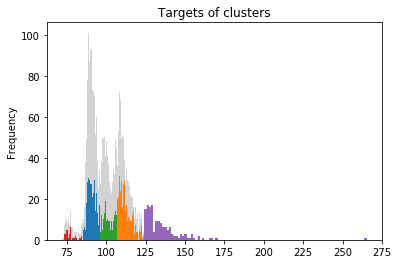

In [18]:
numClusters=5

#Cluster entire dataset, including target

clstr = pd.concat([stacked, pd.DataFrame({'target':yList})], axis =1)
cmodel=cluster.KMeans(n_clusters=numClusters)
cmodel.fit(clstr)

# Add cluster labels into dataframe
clstrd = pd.concat([clstr, pd.DataFrame({'cluster':cmodel.labels_})], axis =1)

# Group by cluster label
grouped = clstrd[['target','cluster']].groupby('cluster')
g=[grouped.get_group(i) for i in range(len(grouped))]

# Plot histogram
numBins=100
clstrd['target'].plot.hist(bins=numBins*len(g),color='lightGray',title='Targets of clusters')
for i in range(len(g)):
    g[i]['target'].plot.hist(bins=numBins)


### Split cluster labels into training and testing sets

In [19]:
cListTrain = [cmodel.labels_[i] for i in range(len(cmodel.labels_)) if i%4!=0]
cListTest = [cmodel.labels_[i] for i in range(len(cmodel.labels_)) if i%4==0]

### Gradient Boosting to predict cluster from data set excluding target

In [20]:
model = ensemble.GradientBoostingClassifier(n_estimators=100,max_depth=1)
model.fit(xListTrain,cListTrain)
print('\tTrain Score:\t', model.score(xListTrain,cListTrain))
print('\tTest Score:\t', model.score(xListTest,cListTest))

	Train Score:	 0.7785171102661597
	Test Score:	 0.7464387464387464


# Summary

<p>Random Forest gave the best score on test data (0.557). Gradient Boosting, Ridge and LARS also performed well.</p>
<p>X314, X261, X127 have highest importance according to Random Forest. Result confirmed by correlation data.</p> 
<p>Data was clustered with kMeans (k=5) and the clusters predicted with GB.</p>  